## Ishan Singh
## MDS202118

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and display a few rows of the data
df=pd.read_csv("/content/drive/My Drive/AML/archive/train.csv",encoding="iso-8859-1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
# Keep only the relevant sections for the model
df = df[['text', 'sentiment']]

# Drop rows with missing values and create a new DataFrame
df = df.dropna()

In [5]:
# Encode labels
sentiment_labels = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['sentiment'].map(sentiment_labels)

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [6]:
# Create dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
        }

In [7]:
# Prepare data
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df['text'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )
    return DataLoader(dataset, batch_size=batch_size)

In [8]:
# Parameters
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 5e-5

In [9]:
# Initialize model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [10]:
# Create data loaders
train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [11]:
# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [12]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [13]:
# Train function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        _, preds = torch.max(outputs.logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

In [14]:
# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    true_labels = []
    predictions = []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            _, preds = torch.max(outputs.logits, dim=1)

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    accuracy = total_correct / total_samples

    return true_labels, predictions, accuracy

In [15]:
# Training loop
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    train_loss, train_accuracy = train_epoch(model, train_data_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

Epoch: 1/3


Epoch: 2/3


Epoch: 3/3


In [18]:
# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive']))


Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.80      0.79       748
     neutral       0.77      0.75      0.76      1141
    positive       0.82      0.85      0.83       859

    accuracy                           0.79      2748
   macro avg       0.79      0.80      0.79      2748
weighted avg       0.79      0.79      0.79      2748



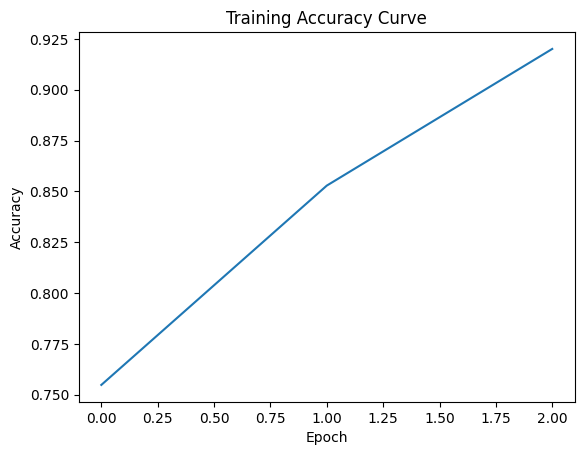

In [19]:
# Plot training accuracy curve
plt.plot(train_accuracies)
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

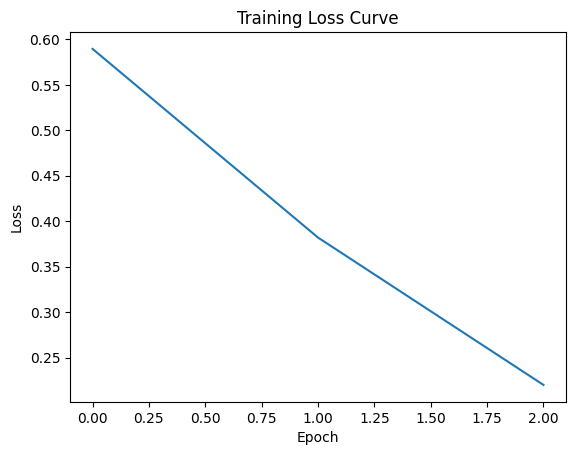

In [20]:
# Plot training loss curve
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

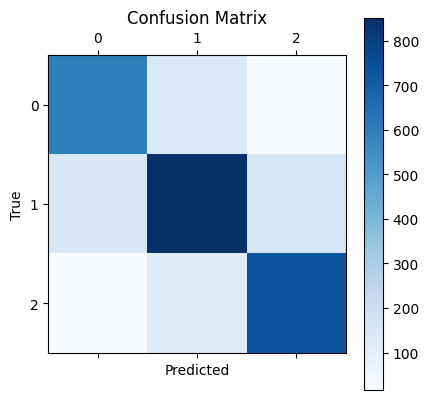

In [21]:
# Plot confusion matrix
true_labels, predictions, _ = eval_model(model, test_data_loader, device)
cm = confusion_matrix(true_labels, predictions)
plt.matshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()